https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1


https://towardsdatascience.com/similarity-metrics-in-nlp-acc0777e234c 

https://www.youtube.com/watch?v=Ey81KfQ3PQU


Model semantic search: 'multi-qa-MiniLM-L6-cos-v1'

Model assymetric : 'msmarco-MiniLM-L-6-v3'

In [1]:
# import sys
# import os

# # Add the 'Functions' directory to the Python path
# sys.path.append(os.path.abspath('../../Functions'))


from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
from Functions.NLP.data_with_nlp import *
from Functions.BERT.bert import *
from Functions.pipeline import *

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
# Import argsort
from numpy import argsort
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt

/home/gabrielabib/.conda/envs/nova/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
protocols = pd.read_csv('/home/gabrielabib/Desktop/PBL/PBLHGO/BERT/protocols_A1.csv')
protocols

,A1,A2,A3,A4,A5,A6
0,Cefaleia crónica,Distúrbios do equilíbrio com quedas frequentes,Doenças neuromusculares e genéticas,Distúrbio de aprendizagem,Demência com dúvida diagnóstica,Doença desmielinizante
1,Cefaleia refratária,Distonia,dores neuropáticas refratárias,Retardo psicomotor,Demência rapidamente progressiva,Esclerose múltipla
2,Enxaqueca persistente,Parkinson,parestesias recorrentes e/ou progressivas,NaN,NaN,Mielite transversa
3,NaN,Tremor essencial,paraplegias e paresias,NaN,NaN,Doença de Devic
4,NaN,Ataxia ou descoordenação motora,esclerose lateral amiotrófica,NaN,NaN,Leucoencefalopatia multifocal progressiva
5,NaN,"Coreia, balismo ou movimentos involuntários",suspeita de miopatias,NaN,NaN,Neurite óptica
6,NaN,NaN,miastenia graves e outros transtornos neuromus...,NaN,NaN,Leucodistrofias
7,NaN,NaN,"amiotrofias espinhais e síndromes correlatas, ...",NaN,NaN,Síndrome de Van der Knaap
8,NaN,NaN,doenças neurogenéticas,NaN,NaN,Doença neuroimunológica
9,NaN,NaN,NaN,NaN,NaN,Doença autoimune


In [8]:
baseline = protocols.columns.to_list()

In [9]:
# # 1. Data cleaning
reference = []

for col in baseline:
    
    protocols2 = protocols.copy()
    protocols2 = protocols2[[col]].dropna()

    lower_text(protocols2,col, col)
    remove_stop_words(protocols2,col, col)
    spacy_lemmatizer(protocols2,col, col)

    reference.append(list(protocols2[col].dropna()))

    
# [reference.append(list(spacy_lemmatizer(remove_stop_words(lower_text(protocols[[col]].copy().dropna(), col), col), col)[col].dropna())) for col in baseline]

reference

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-d

[['cefaleia crónico', 'cefaleia refratária', 'enxaqueca persistente'],
 ['distúrbio equilíbrio queda frequente',
  'distonia',
  'parkinson',
  'tremor essencial',
  'ataxio descoordenação motoro',
  'coreia balismo movimento involuntário'],
 ['doença neuromuscular genético',
  'dor neuropático refratário',
  'parestesia recorrente e/ou progressivo',
  'paraplegia paresio',
  'esclerose lateral amiotrófico',
  'suspeito miopatia',
  'miastenia grave outro transtorno neuromuscular',
  'amiotrofia espinhal síndromes correlato polineuropatia outro transtorno sistema nervoso periférico snp',
  'doença neurogenético'],
 ['distúrbio aprendizagem', 'retardo psicomotor'],
 ['demência dúvido diagnósticar', 'demência rapidamente progressivo'],
 ['doença desmielinizante',
  'esclerose múltiplo',
  'mielite transverso',
  'doença devic',
  'leucoencefalopatia multifocal progressivo',
  'neurite óptico',
  'leucodistrofia',
  'síndrome van der knaap',
  'doença neuroimunológico',
  'doença autoimun

In [10]:
alertP1 = connection('credentials.txt')
data = pre_process(alertP1)


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
104


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
model_name = 'pucpr/biobertpt-all'
# model_name = 'sentence-transformers/msmarco-MiniLM-L-6-v3'

In [12]:
from sentence_transformers import SentenceTransformer

In [13]:
data = bert_split_referrals(data, reference, model_name = model_name)
data

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
No sentence-transformers model found with name /home/gabrielabib/.cache/torch/sentence_transformers/pucpr_biobertpt-all. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/gabrielabib/.cache/torch/sentence_transformers/pucpr_biobertpt-all were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,USF A,USF B,outro,not accepted before,0_score,1_score,2_score,3_score,4_score,5_score
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,1,0,0,1,0.635264,0.757666,0.784365,0.693260,0.733718,0.713683
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0,0,0,1,0.673758,0.644741,0.697994,0.684537,0.691746,0.678719
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,1,0.493361,0.595500,0.582237,0.540994,0.538914,0.498724
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,1,0.579779,0.683735,0.655982,0.634297,0.641665,0.622921
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,1,0,1,0.720869,0.713373,0.832182,0.709960,0.732715,0.889079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,1,0.694523,0.745617,0.759714,0.693663,0.771798,0.725335
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,1,0,1,0.685868,0.754030,0.814398,0.703269,0.759391,0.757504
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,0,0.737894,0.760588,0.828383,0.719626,0.741348,0.705122
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,1,0,1,0.746019,0.791994,0.768395,0.711543,0.740396,0.773360


In [14]:
# alertP1_simplified.describe()
import xgboost as xgb


In [15]:
def precision_at_k(y_true, y_pred, k):
    y_true = y_true.to_numpy()
    # Get the indices of the top k predictions
    top_k_indices = np.argsort(y_pred)[-k:]
    # Get the top k predictions
    top_k_predictions = y_true[top_k_indices]
    # Calculate precision@k
    precision = np.sum(top_k_predictions) / k
    return precision

In [16]:
def xgb_classifier(features, target):
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    # X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    # X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test    

In [17]:
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,USF A,USF B,outro,not accepted before,0_score,1_score,2_score,3_score,4_score,5_score
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,1,0,0,1,0.635264,0.757666,0.784365,0.693260,0.733718,0.713683
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0,0,0,1,0.673758,0.644741,0.697994,0.684537,0.691746,0.678719
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,1,0.493361,0.595500,0.582237,0.540994,0.538914,0.498724
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,1,0.579779,0.683735,0.655982,0.634297,0.641665,0.622921
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,1,0,1,0.720869,0.713373,0.832182,0.709960,0.732715,0.889079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,1,0.694523,0.745617,0.759714,0.693663,0.771798,0.725335
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,1,0,1,0.685868,0.754030,0.814398,0.703269,0.759391,0.757504
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,0,0.737894,0.760588,0.828383,0.719626,0.741348,0.705122
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,1,0,1,0.746019,0.791994,0.768395,0.711543,0.740396,0.773360


In [18]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score

def evaluate_thresholds(y_pred_train, y_train, y_pred_test, y_test, metrics = "test", k=211):
    #Precion@k
    def precision_at_k(y_true, y_pred, k):
        y_true = y_true.to_numpy()
        # Get the indices of the top k predictions
        top_k_indices = np.argsort(y_pred)[-k:]
        # Get the top k predictions
        top_k_predictions = y_true[top_k_indices]
        # Calculate precision@k
        precision = np.sum(top_k_predictions) / k
        return precision

    if metrics == "test":
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_test >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_test, default_y_pred_binary)
        default_recall = recall_score(y_test, default_y_pred_binary)
        default_precision = precision_score(y_test, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_test, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_test >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
        pr_recall = recall_score(y_test, pr_y_pred_binary)
        pr_precision = precision_score(y_test, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_test, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_test >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
        ba_recall = recall_score(y_test, ba_y_pred_binary)
        ba_precision = precision_score(y_test, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_test, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
        kappa_recall = recall_score(y_test, kappa_y_pred_binary)
        kappa_precision = precision_score(y_test, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_test, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_test >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_test, limit_to_k_y_pred_binary, k)

    else:
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_train >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_train, default_y_pred_binary)
        default_recall = recall_score(y_train, default_y_pred_binary)
        default_precision = precision_score(y_train, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_train, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_train >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_train, pr_y_pred_binary)
        pr_recall = recall_score(y_train, pr_y_pred_binary)
        pr_precision = precision_score(y_train, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_train, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_train >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_train, ba_y_pred_binary)
        ba_recall = recall_score(y_train, ba_y_pred_binary)
        ba_precision = precision_score(y_train, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_train, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_train >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_train, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_train, kappa_y_pred_binary)
        kappa_recall = recall_score(y_train, kappa_y_pred_binary)
        kappa_precision = precision_score(y_train, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_train, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_train >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_train, limit_to_k_y_pred_binary, k)

    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa", 'Limit to K'],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2), round(limit_to_k_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2), round(limit_to_k_accuracy, 2)],
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2), round(limit_to_k_recall, 2)],
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2), round(limit_to_k_precision, 2)],
        'Precision@211': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df



In [20]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.95,0.81,0.90
1,Precision-Recall trade-off,0.54,0.82,0.94,0.83,0.90
2,Balanced Accuracy,0.66,0.79,0.81,0.87,0.91
3,Cohen's Kappa,0.59,0.82,0.89,0.85,0.92
4,Limit to K,0.64,0.79,0.83,0.87,0.89


In [21]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.69,0.94,0.69,0.72
1,Precision-Recall trade-off,0.54,0.68,0.91,0.70,0.71
2,Balanced Accuracy,0.66,0.74,0.83,0.78,0.77
3,Cohen's Kappa,0.59,0.71,0.88,0.73,0.73
4,Limit to K,0.64,0.73,0.86,0.76,0.76


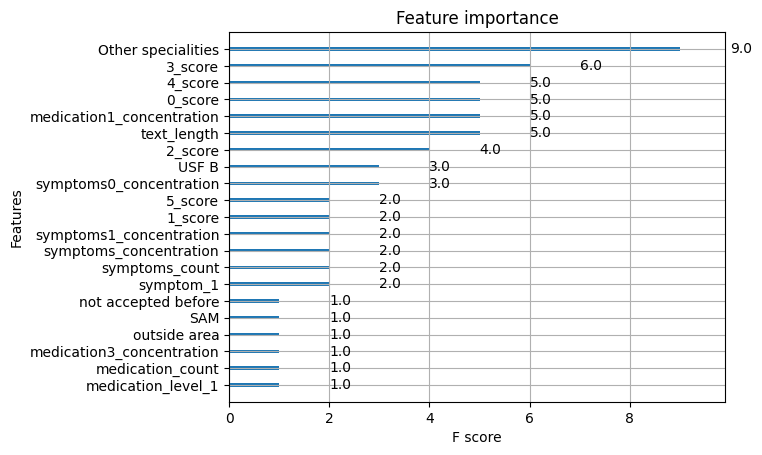

In [22]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [24]:
# columns_bert = ['accep_prot_0', 'accep_prot_1', 'accep_prot_2', 'accep_prot_3', 'accep_prot_4', 'accep_prot_5', 'rej_prot_0', 'rej_prot_1', 'rej_prot_2', 'rej_prot_3', 'rej_prot_4', 'rej_prot_5', 'rej_prot_6', 'rej_prot_7']
# columns_bert = ['acc_prot_0','acc_prot_1','acc_prot_2','acc_prot_3','acc_prot_4','acc_prot_5','rej_prot_0','rej_prot_1','rej_prot_2','rej_prot_3','rej_prot_4','rej_prot_5','rej_prot_6','rej_prot_7']
desirable = ['0_score','1_score','2_score','3_score','4_score','5_score','6_score','7_score']

data[desirable].describe()

KeyError: "['6_score', '7_score'] not in index"

In [ ]:
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,outro,not accepted before,0_score,1_score,2_score,3_score,4_score,5_score,6_score,7_score
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0,1,0.712539,0.734610,0.708840,0.749397,0.693420,0.860880,0.641511,0.662344
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0,1,0.674460,0.728945,0.651231,0.569002,0.726388,0.690755,0.590897,0.780447
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0.545223,0.549920,0.614298,0.437545,0.462401,0.570520,0.453643,0.537904
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0.635063,0.617378,0.710972,0.749397,0.585529,0.860880,0.598020,0.613320
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,1,0.750715,0.707233,0.709556,0.654274,0.673791,0.729534,0.776241,0.715079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,1,0.695103,0.726155,0.739377,0.749397,0.670643,0.860880,0.635342,0.717178
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,1,0.748109,0.716278,0.720857,0.749397,0.717522,0.860880,0.646947,0.741450
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0.740335,0.719943,0.740715,0.614262,0.653421,0.765006,0.748342,0.689061
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,1,0.753181,0.729963,0.738353,0.860129,0.689660,0.853530,0.711017,0.708177


In [ ]:
data2 = data.copy()

# Calculate quartiles for each score column

score_cols = desirable  # replace with your actual column names
quartile_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']

for col in score_cols:
    quartile_bins = [0, data2[col].quantile(0.25), data2[col].quantile(0.5), data2[col].quantile(0.75), data2[col].quantile(0.90), float('inf')]
    data2[col + '_quartile'] = pd.cut(data2[col], bins=quartile_bins, labels=quartile_labels, duplicates='drop')



ValueError: Bin labels must be one fewer than the number of bin edges

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 84 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [ ]:
results = pd.DataFrame({'quartile': quartile_labels})

columns_quartile = ['0_score_quartile','1_score_quartile','2_score_quartile','3_score_quartile','4_score_quartile','5_score_quartile','6_score_quartile','7_score_quartile']


for i , col in enumerate(columns_quartile):
    teste = data2.groupby(col)['result'].sum().reset_index()
    teste.rename(columns={'result': 'sum_'+str(i)}, inplace=True)
    teste2 = data2.groupby(col)['result'].count().reset_index()
    teste2.rename(columns={'result': 'count_'+str(i)}, inplace=True)
    results = results.merge(teste, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results = results.merge(teste2, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results[desirable[i]] = results['sum_'+str(i)]/results['count_'+str(i)]
    results = results.drop(['sum_'+str(i),'count_'+str(i)],axis=1)
  


results

,quartile,0_score,1_score,2_score,3_score,4_score,5_score,6_score,7_score
0,1st Quartile,0.460154,0.690537,0.646617,0.695000,0.696742,0.537736,0.462766,0.699752
1,2nd Quartile,0.716418,0.721393,0.462687,0.485075,0.475845,0.738182,0.679104,0.763682
2,3rd Quartile,0.776119,0.537313,0.781095,0.771144,0.752577,0.743781,0.738806,0.522388
3,4th Quartile,0.775934,0.788382,0.858921,0.788382,0.813278,0.834025,0.853755,0.751037
4,90_quantile,0.739130,0.770186,0.807453,0.776398,0.826087,0.689441,0.812081,0.739130


## Model with  R2 and R6 only

In [ ]:
desirable = ['2_score','6_score']

undesirable = ['0_score','1_score','3_score','4_score','5_score','7_score']

In [ ]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text'] + undesirable
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [ ]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.95,0.80,0.88
1,Precision-Recall trade-off,0.54,0.82,0.93,0.83,0.90
2,Balanced Accuracy,0.70,0.78,0.75,0.91,0.95
3,Cohen's Kappa,0.63,0.81,0.84,0.88,0.91
4,Limit to K,0.64,0.80,0.83,0.88,0.92


In [ ]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.69,0.97,0.69,0.71
1,Precision-Recall trade-off,0.54,0.69,0.91,0.71,0.72
2,Balanced Accuracy,0.70,0.70,0.72,0.80,0.78
3,Cohen's Kappa,0.63,0.72,0.82,0.77,0.76
4,Limit to K,0.64,0.72,0.82,0.77,0.77


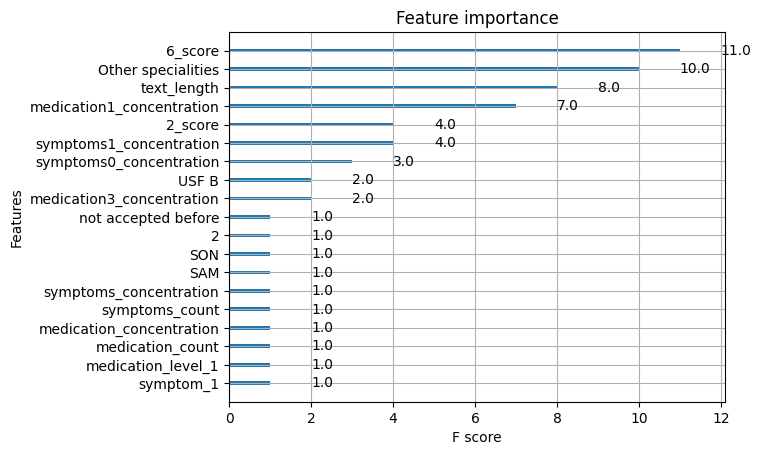

In [ ]:
# Plot the feature importance scores
plot_importance(model_score)
plt.show()